# Requirements

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import nltk
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import seaborn as sns
import geoplot
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library
import sddk
import tempun

In [305]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")
figpath = "SDAM_data/social_diversity/socdiv_figures/"

Your ScienceData username (e.g. '123456@au.dk'): 648597@au.dk
Your ScienceData password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [3]:
file_data = s.read_file("https://sciencedata.dk/files/ServiceAccountsKey.json", "dict")
credentials = service_account.Credentials.from_service_account_info(file_data)
gc = gspread.Client(auth=credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']))
socdiv_results = gc.open_by_url("https://docs.google.com/spreadsheets/d/1kACGBS9Xdno7FL2fPZ-vCOu4SSh9uUaZmGvnEghVs_A/edit?usp=sharing")

# Import dataset

In [4]:
EDHCS = s.read_file("SDAM_data/social_diversity/EDHCS_occupsorgs_2021-05-27.geojson", "gdf")
EDHCS.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,city_id_hanson,city_pop_est,city_geometry,nearest_city_type,nearest_city_dist,occups,occups_N,organizations,organizations_N,geometry
0,EDCS-71300269,"AE 2014, 01203",Achaia,Achaia,Mavrommati / Mavromati / Messini / Messene,"['Mavrommati', 'Mavromati', 'Messini', 'Messene']",96,,"['sigilla impressa', 'tituli fabricationis', '...",tituli fabricationis,...,59,22337.0,"[22.008029, 37.051363]",middle,0.153060,[],0,[],0,POINT (21.92418 37.17941)
1,EDCS-21200140,"CIL 03, 00079 = CIL 03, 14147,6 = IDakke 00028",Aegyptus,Aegyptus,Ad-Dakka / El-Dakka / Dakke / Pselqet / Pselki...,"['Ad-Dakka', 'El-Dakka', 'Dakke', 'Pselqet', '...",109,,"['milites', 'tituli fabricationis', 'tituli sa...","['tituli fabricationis', 'tituli sacri']",...,126,33806.0,"[32.933333, 24.083333]",big,0.902158,[],0,[],0,POINT (32.75000 23.20000)
2,EDCS-21200142,"CIL 03, 00081 = CIL 03, 13584 = IDakke 00064a",Aegyptus,Aegyptus,Ad-Dakka / El-Dakka / Dakke / Pselqet / Pselki...,"['Ad-Dakka', 'El-Dakka', 'Dakke', 'Pselqet', '...",109,,{},{},...,126,33806.0,"[32.933333, 24.083333]",big,0.902158,[],0,[],0,POINT (32.75000 23.20000)
3,EDCS-52100002,IDakke 00064,Aegyptus,Aegyptus,Ad-Dakka / El-Dakka / Dakke / Pselqet / Pselki...,"['Ad-Dakka', 'El-Dakka', 'Dakke', 'Pselqet', '...",109,,tituli possessionis,tituli possessionis,...,126,33806.0,"[32.933333, 24.083333]",big,0.902158,[],0,[],0,POINT (32.75000 23.20000)
4,EDCS-44500113,IDakke 00100,Aegyptus,Aegyptus,Ad-Dakka / El-Dakka / Dakke / Pselqet / Pselki...,"['Ad-Dakka', 'El-Dakka', 'Dakke', 'Pselqet', '...",117,,"['Augusti/Augustae', 'milites', 'ordo equester...",tituli sacri,...,126,33806.0,"[32.933333, 24.083333]",big,0.902158,[],0,[],0,POINT (32.75000 23.20000)


# Occupations by cities

In [7]:
print(list(EDHCS.columns))

['EDCS-ID', 'publication', 'province', 'province_list', 'place', 'place_list', 'end_yr_list', 'notes_dating', 'status_list', 'inscr_type', 'status_notation', 'inscr_process', 'notes_references', 'notes_comments', 'inscription', 'inscription_stripped_final', 'Links', 'dating from', 'dating to', 'status', 'Latitude', 'Longitude', 'photo', 'Material', 'Comment', 'EDH-ID', 'language_EDCS', 'clean_text_interpretive_word_EDCS', 'responsible_individual', 'type_of_inscription', 'letter_size', 'literature', 'work_status', 'height', 'diplomatic_text', 'people', 'depth', 'material', 'type_of_monument', 'province_label', 'width', 'transcription', 'country', 'uri', 'findspot_ancient', 'last_update', 'modern_region', 'findspot_modern', 'edh_geography_uri', 'commentary', 'trismegistos_uri', 'external_image_uris', 'fotos', 'idno_tm', 'placenames_refs', 'text_edition', 'origdate_text', 'layout_execution', 'layout_execution_text', 'support_objecttype', 'support_objecttype_text', 'support_material', 'sup

In [171]:
len(EDHCS[EDHCS["occups_N"] > 0])

3293

In [196]:
# import Hanson's dataset of cities
cities_hanson = gpd.read_file("../data/roman_cities_pop.geojson", driver="GeoJSON")
len(cities_hanson)

1388

In [216]:
cities_hanson

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,Estimate Basis,num_of_structures,ID,level_0,Unnamed: 0_y,index,pop_sample,pop_est,pop_diff,geometry
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,...,Walls,5,1,NaN,NaN,NaN,NaN,1700.0,NaN,POINT (22.93333 38.58333)
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,BNP; DGRG; PECS; Sear 2006.,...,None,3,2,NaN,NaN,NaN,NaN,1000.0,NaN,POINT (23.73409 38.08347)
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,...,None,7,3,NaN,NaN,NaN,NaN,1000.0,NaN,POINT (23.21970 38.45261)
3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...,...,Inhabited area,8,4,NaN,NaN,NaN,NaN,8209.0,NaN,POINT (23.42850 37.75007)
4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,DGRG; Hansen and Nielsen 2004.,...,None,8,5,NaN,NaN,NaN,NaN,1000.0,NaN,POINT (22.35572 38.14795)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383,Hanson2016_1384,Pautalia,Kyustendi,Thracia,Bulgaria,3,49 E1,98,NaN,BNP; DGRG; Jones 1937; PECS; Wilkes 2003b.,...,None,11,1384,NaN,NaN,NaN,NaN,1000.0,NaN,POINT (22.68075 42.28252)
1384,Hanson2016_1385,Philippopolis (Thracia),Plovdiv,Thracia,Bulgaria,2,22 B6,-342,NaN,BNP; Cohen 1995; DGRG; Hansen and Nielsen 2004...,...,Walls,12,1385,NaN,NaN,NaN,NaN,14111.0,NaN,POINT (24.75091 42.14665)
1385,Hanson2016_1386,Samothrace,Samothrace,Thracia,Greece,3,51 F3,-700,NaN,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,...,Walls,6,1386,NaN,NaN,NaN,NaN,3252.0,NaN,POINT (25.52925 40.50069)
1386,Hanson2016_1387,Serdica,Sophia,Thracia,Bulgaria,2,21 F7,45,NaN,BNP; DGRG; Jones 1937; PECS; Sear 2006; Wilkes...,...,Inhabited area,9,1387,NaN,NaN,NaN,NaN,15580.0,NaN,POINT (23.34289 42.72283)


In [197]:
cities_hanson["pop_est"].sum()

10159670.0

In [250]:
# select modern countries with Latin
countries_latin = ["Tunisia", "Italy", "Switzerland", "France", 'Spain', 'United Kingdom', 'Romania', 'Croatia', 'Montenegro', 'Bosnia and Herzegovina', 'Serbia', 'Germany', 'Belgium', 'Netherlands', 'Portugal', 'Slovenia', 'Algeria', 'Morocco', 'Kosovo', 'Austria', 'Hungary']
# use these countries to filter for cities
cities_latin = cities_pop[cities_pop["Country"].isin(countries_latin)]
len(cities_latin)

908

<AxesSubplot:>

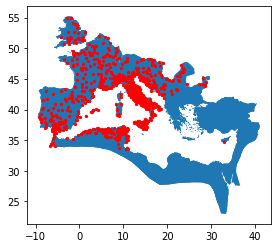

In [251]:
fig, ax = plt.subplots()
pleiades_regions.plot(ax=ax)
cities_latin.plot(ax=ax, color="red", markersize=5)

In [252]:
# The city on Cyprus is Curium, which is now under the control of United Kingdom
cities_latin[cities_latin["Ancient Toponym"] == "Curium"]

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,Estimate Basis,num_of_structures,ID,level_0,Unnamed: 0_y,index,pop_sample,pop_est,pop_diff,geometry
442,Hanson2016_443,Curium,Kourion,Cilicia et Cyprus,United Kingdom,3,72 B3,-700,NaN,BNP; Hansen and Nielsen 2004; PECS; Sear 2006;...,...,None,8,443,NaN,NaN,NaN,NaN,1000.0,NaN,POINT (32.88770 34.66420)


<AxesSubplot:>

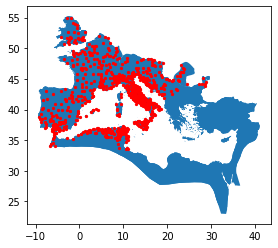

In [254]:
cities_latin = cities_latin[cities_latin["Ancient Toponym"] != "Curium"]
fig, ax = plt.subplots()
pleiades_regions.plot(ax=ax)
cities_latin.plot(ax=ax, color="red", markersize=5)

In [255]:
cities_latin["pop_est"].sum()

5269318.0

In [256]:
%%time
cities_occups_data = []
for city in cities_latin["Ancient Toponym"].tolist():
    city_hanson = cities_hanson[cities_hanson["Ancient Toponym"]==city]
    edhcs_city_df = EDHCS[EDHCS["nearest_city"]==city]
    ins_N = len(edhcs_city_df)
    occups_lists = [eval(el) for el in edhcs_city_df["occups"].tolist()]
    occups_unique_list = list(set([el for sublist in occups_lists for el in sublist]))
    occups_unique_N = len(occups_unique_list)
    occups_N = edhcs_city_df["occups_N"].sum()
    city_data = {
        "city" : city,
        "pop_est" : city_hanson["pop_est"].tolist()[0], 
        "Country" : city_hanson["Country"].tolist()[0], 
        "geometry" : city_hanson["geometry"].tolist()[0],
        "ins_N" : ins_N,
        "unique_occups" : occups_unique_list,
        "occups_N" : occups_N,
        "unique_occups_N" : occups_unique_N
    }
    cities_occups_data.append(city_data)
cities_occups_df = pd.DataFrame(cities_occups_data)
cities_occups_gdf = gpd.GeoDataFrame(cities_occups_df)

CPU times: user 31.4 s, sys: 110 ms, total: 31.6 s
Wall time: 31.6 s


In [304]:
cities_occups_gdf

,city,pop_est,Country,geometry,ins_N,unique_occups,occups_N,unique_occups_N
0,Abbir Maius,1000.0,Tunisia,POINT (10.00883 36.37400),2,[],0,0
1,Abitinae,1000.0,Tunisia,POINT (9.54908 36.62788),3,[],0,0
2,Abthungi,4837.0,Tunisia,POINT (10.01979 36.19989),3,[],0,0
3,Acholla,1000.0,Tunisia,POINT (11.01873 35.07824),3,[],0,0
4,Agbia,1000.0,Tunisia,POINT (9.22993 36.39139),14,[],0,0
...,...,...,...,...,...,...,...,...
902,Segesta,4471.0,Italy,POINT (12.83238 37.94135),29,[],0,0
903,Soluntum,1559.0,Italy,POINT (13.53174 38.09266),0,[],0,0
904,Syracusae,83831.0,Italy,POINT (15.28444 37.06648),5,[],0,0
905,Tauromenium,11060.0,Italy,POINT (15.28792 37.85307),3,[],0,0


In [345]:
cities_occups_gdf.sort_values("pop_est", ascending=False, inplace=True)
cities_occups_gdf.reset_index(drop=True, inplace=True)
cities_occups_gdf["index"] = cities_occups_gdf.index
cities_occups_gdf.head(5)

,city,pop_est,Country,geometry,ins_N,unique_occups,occups_N,unique_occups_N,pop_est_log,index
0,Roma,923313.0,Italy,POINT (12.48510 41.89278),37769,"[ornator, signarius, calciator, gerulus, vesti...",1288,203,5.965349,0
1,Carthago,102074.0,Tunisia,POINT (10.32769 36.85132),411,"[medicus, mensor, argentarius, mesor, agrimensor]",7,5,5.008915,1
2,Syracusae,83831.0,Italy,POINT (15.28444 37.06648),5,[],0,0,4.923405,2
3,Agrigentum,53332.0,Italy,POINT (13.57696 37.31119),5,[],0,0,4.726988,3
4,Vindobriga (Gallia Aquitania) (1),49650.0,France,POINT (0.30974 46.73545),0,[],0,0,4.695919,4


In [389]:
cities_occups_gdf["pop_est_log"] = cities_occups_gdf["pop_est"].apply(np.log10)
cities_occups_gdf["ins_N_log"] = cities_occups_gdf["ins_N"].apply(np.log10)
cities_occups_gdf["ins_N_log2"] = cities_occups_gdf["ins_N"].apply(np.log2)

<AxesSubplot:xlabel='index', ylabel='pop_est_log'>

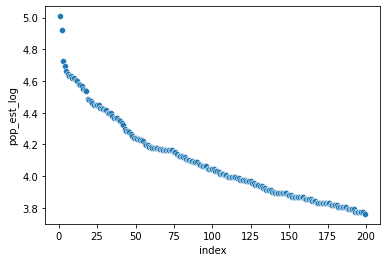

In [390]:
cities_occups_gdf.sort_values("pop_est", ascending=False, inplace=True)
cities_occups_gdf.reset_index(drop=True, inplace=True)
cities_occups_gdf["index"] = cities_occups_gdf.index
sns.scatterplot(x="index", y="pop_est_log", data=cities_occups_gdf[1:200])

<AxesSubplot:xlabel='pop_est_log', ylabel='ins_N_log2'>

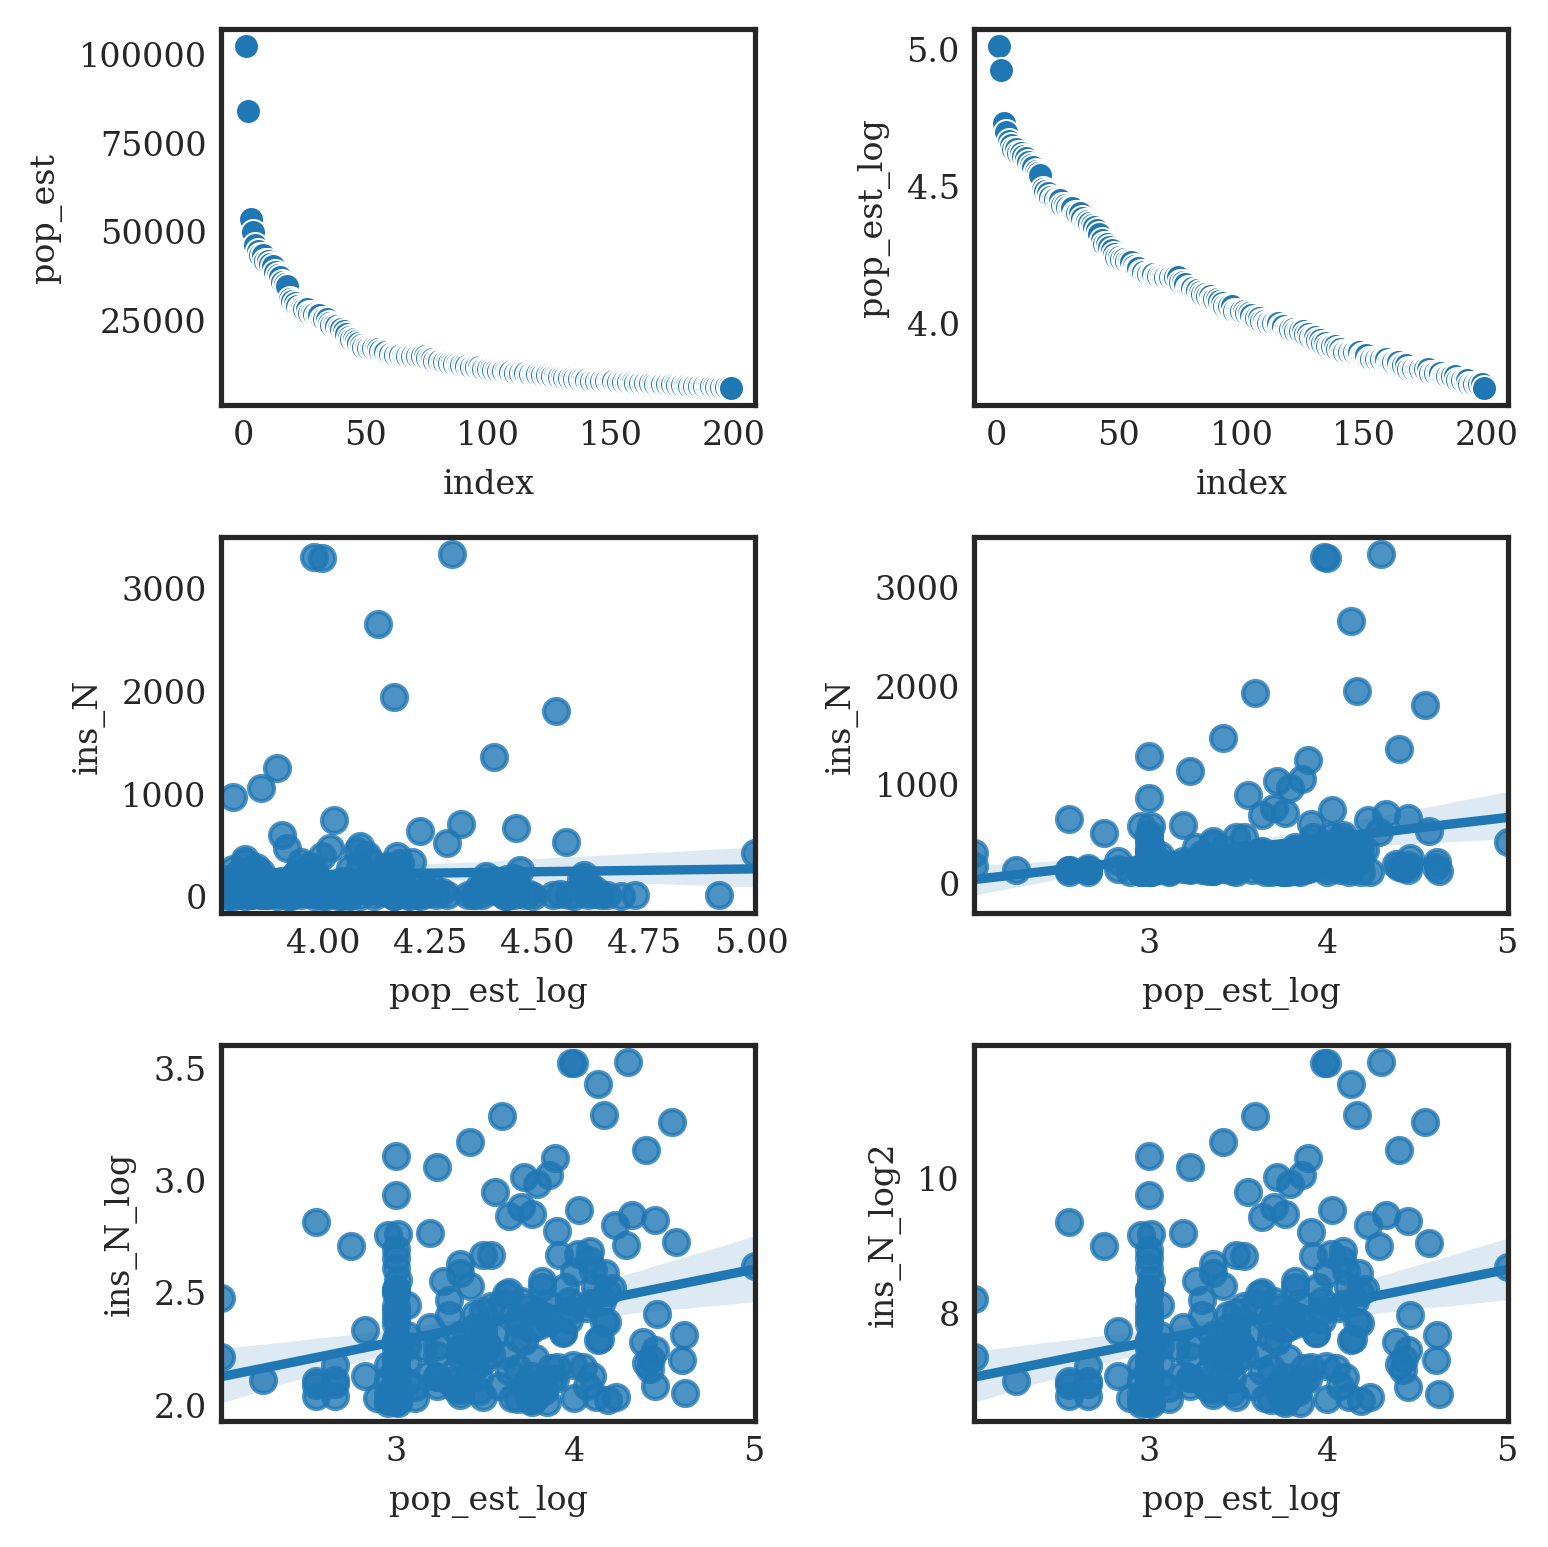

In [399]:
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

fig, axs = plt.subplots(3,2, figsize=[5.2, 5.2], tight_layout=True)

# 1) pop
sns.scatterplot(x="index", y="pop_est", data=cities_occups_gdf[1:200], ax=axs[0][0])
# 2) pop log10
sns.scatterplot(x="index", y="pop_est_log", data=cities_occups_gdf[1:200], ax=axs[0][1])
# 3) pop log10 vs ins N
sns.regplot(x ='pop_est_log', y ='ins_N', data = cities_occups_gdf[1:200], ax=axs[1][0])
# 4) pop log10 vs ins N in cities where is at least certain number of inscriptions
sns.regplot(x ='pop_est_log', y ='ins_N', data = cities_occups_gdf[cities_occups_gdf["ins_N"]>100][1:], ax=axs[1][1])
# 5) pop log10 vs ins N in cities where is at least certain number of inscriptions
sns.regplot(x ='pop_est_log', y ='ins_N_log', data = cities_occups_gdf[cities_occups_gdf["ins_N"]>100][1:], ax=axs[2][0])
# 6) pop log10 vs ins N in cities where is at least certain number of inscriptions
sns.regplot(x ='pop_est_log', y ='ins_N_log2', data = cities_occups_gdf[cities_occups_gdf["ins_N"]>100][1:], ax=axs[2][1])

In [384]:
# by countries
countries_occups_gdf = cities_occups_gdf.groupby("Country").sum().sort_values("ins_N", ascending=False).reset_index()[['Country','pop_est','ins_N','occups_N']]
countries_occups_gdf.head(10)

,Country,pop_est,ins_N,occups_N
0,Italy,2568971.0,72685,2702
1,Germany,105971.0,9886,173
2,Spain,305289.0,8561,165
3,Croatia,103753.0,5357,85
4,France,980127.0,5281,108
5,Romania,73167.0,5188,128
6,United Kingdom,182896.0,4469,41
7,Austria,52585.0,4202,71
8,Hungary,26013.0,3957,129
9,Algeria,203262.0,3573,21


In [382]:
countries_occups_gdf["Country"].tolist()[:6]

['Country',
 'pop_est',
 'ins_N',
 'occups_N',
 'unique_occups_N',
 'pop_est_log',
 'index',
 'ins_N_log',
 'ins_N**2',
 'ins_N_log10',
 'ins_N_log2']

### Pop (log10) vs inscriptions N

array([<AxesSubplot:title={'center':'United Kingdom'}>,
       <AxesSubplot:title={'center':'Austria'}>,
       <AxesSubplot:title={'center':'Hungary'}>], dtype=object)

[Text(0.5, 0, ''),
 Text(0.5, 0, ''),
 Text(0.5, 0, ''),
 Text(0.5, 0, ''),
 Text(0.5, 0, ''),
 Text(0.5, 0, '')]

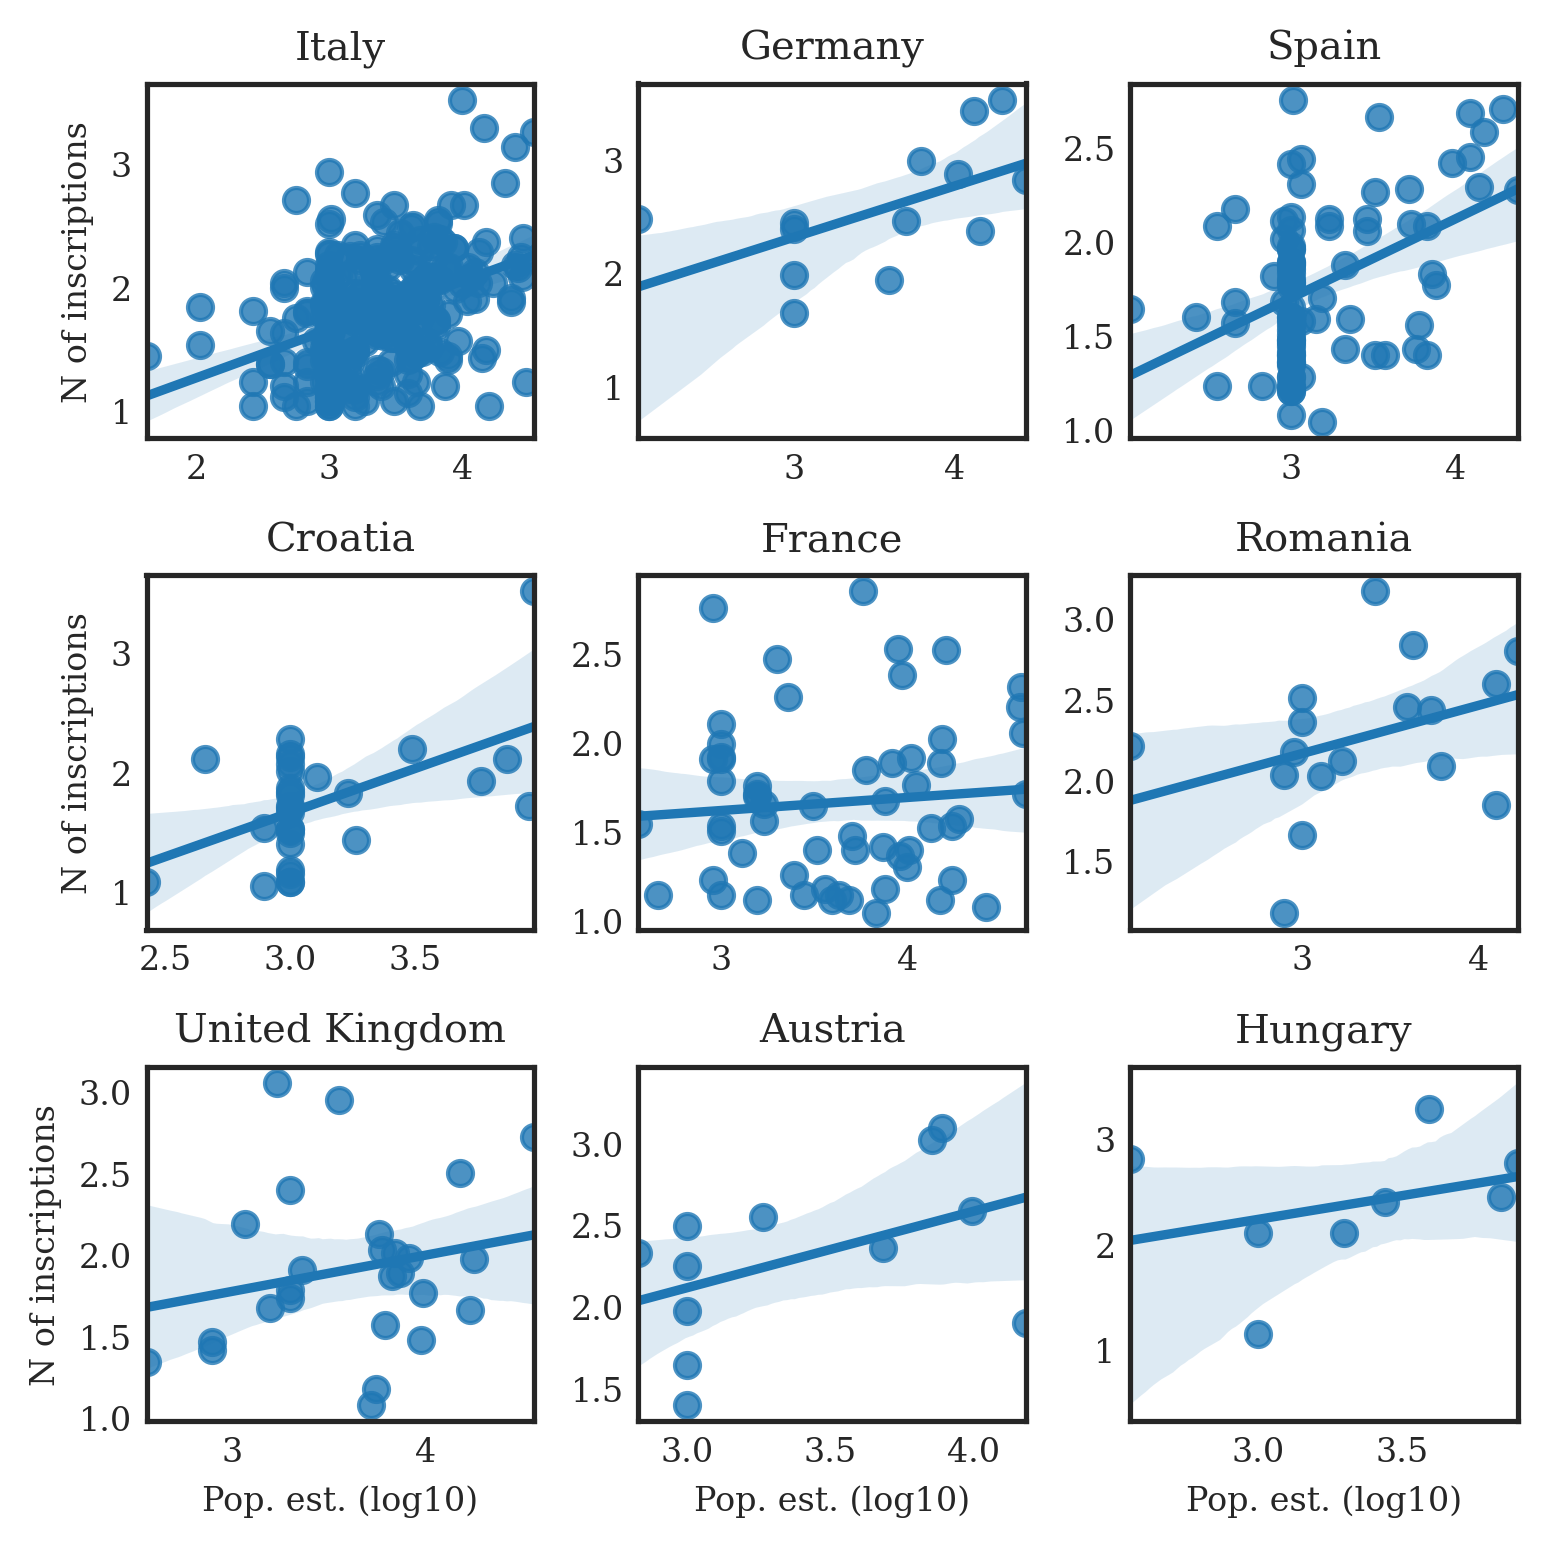

In [463]:
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

fig, axs = plt.subplots(3,3, figsize=[5.2, 5.2], tight_layout=True)
for country, ax in zip(countries_occups_gdf["Country"].tolist()[:9], axs.ravel()):
    country_df = cities_occups_gdf[cities_occups_gdf["Country"]==country]
    if country == "Italy":
        country_df =country_df [1:]
    sns.regplot(x ='pop_est_log', y ='ins_N_log', data = country_df[country_df["ins_N"]>10][:], ax=ax)
    ax.set_title(country) #, loc="left", y=1, pad=-10)
    #ax.set_title("  " + country, loc="left", y=1, pad=-10)
    ax.set_ylabel("N of inscriptions")
    ax.set_xlabel("Pop. est. (log10)")
    
[ax.set_ylabel("") for ax in axs[:,1:].ravel()]
[ax.set_xlabel("") for ax in axs[:2,:].ravel()]

In [464]:
figpath = "SDAM_data/social_diversity/socdiv_figures/"
s.write_file(figpath + "cites_pop_vs_insN.png", fig)
s.write_file(figpath + "cites_pop_vs_insN.eps", fig)

A file with the same name ("cites_pop_vs_insN.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/cites_pop_vs_insN.png"
A file with the same name ("cites_pop_vs_insN.eps") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/cites_pop_vs_insN.eps"


[Text(0.5, 0, ''),
 Text(0.5, 0, ''),
 Text(0.5, 0, ''),
 Text(0.5, 0, ''),
 Text(0.5, 0, ''),
 Text(0.5, 0, '')]

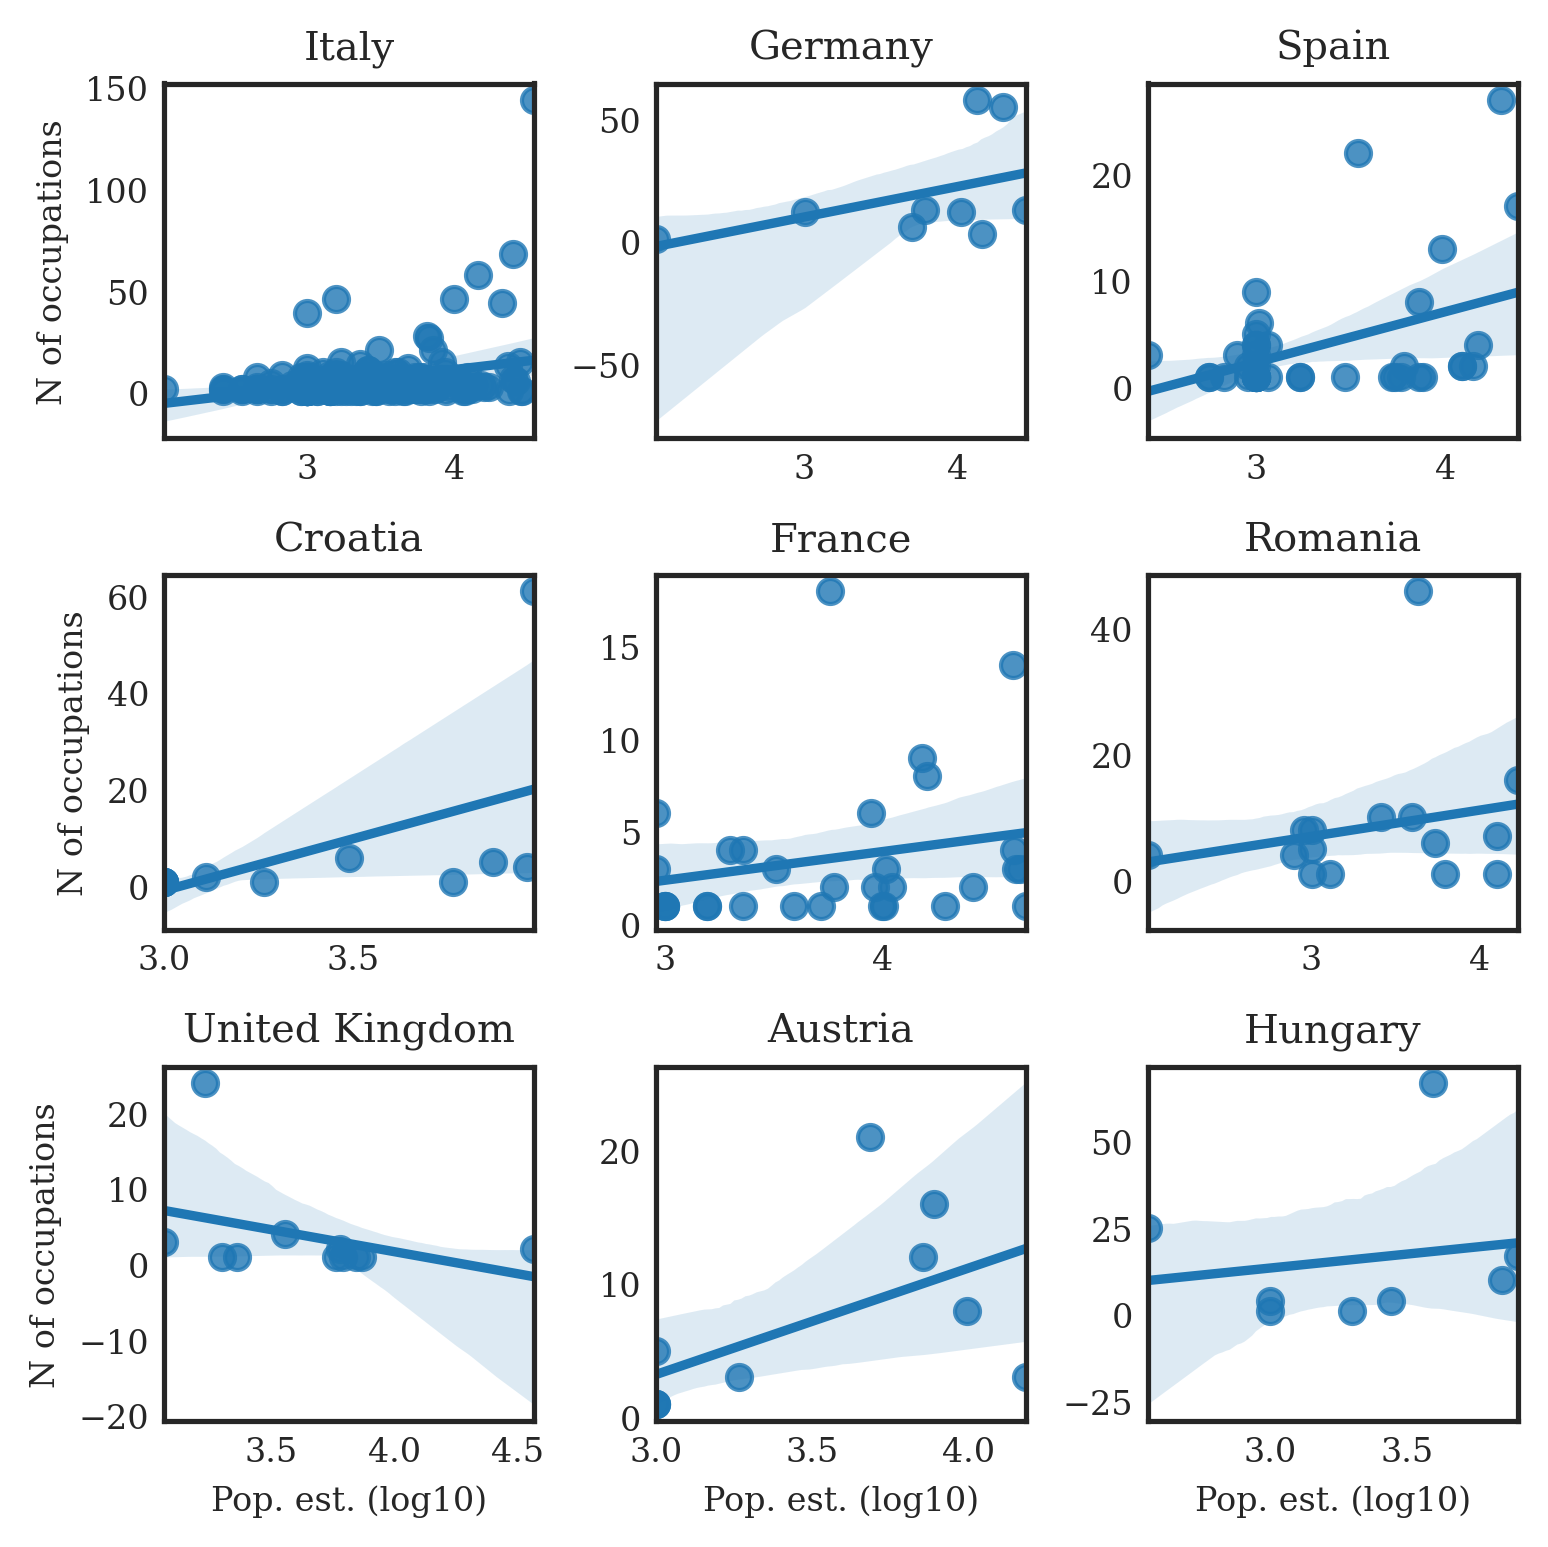

In [461]:
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

fig, axs = plt.subplots(3,3, figsize=[5.2, 5.2], tight_layout=True)
for country, ax in zip(countries_occups_gdf["Country"].tolist()[:9], axs.ravel()):
    country_df = cities_occups_gdf[cities_occups_gdf["Country"]==country]
    if country == "Italy":
        country_df =country_df [1:]
    sns.regplot(x ='pop_est_log', y ='occups_N', data = country_df[country_df["occups_N"]>0][:], ax=ax)
    ax.set_title(country)
    ax.set_ylabel("N of occupations")
    ax.set_xlabel("Pop. est. (log10)")
[ax.set_ylabel("") for ax in axs[:,1:].ravel()]
[ax.set_xlabel("") for ax in axs[:2,:].ravel()]

In [462]:
s.write_file(figpath + "cites_pop_vs_occupsN.png", fig)
s.write_file(figpath + "cites_pop_vs_occupsN.eps", fig)

A file with the same name ("cites_pop_vs_occupsN.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/cites_pop_vs_occupsN.png"
A file with the same name ("cites_pop_vs_occupsN.eps") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/cites_pop_vs_occupsN.eps"


[Text(0.5, 0, ''),
 Text(0.5, 0, ''),
 Text(0.5, 0, ''),
 Text(0.5, 0, ''),
 Text(0.5, 0, ''),
 Text(0.5, 0, '')]

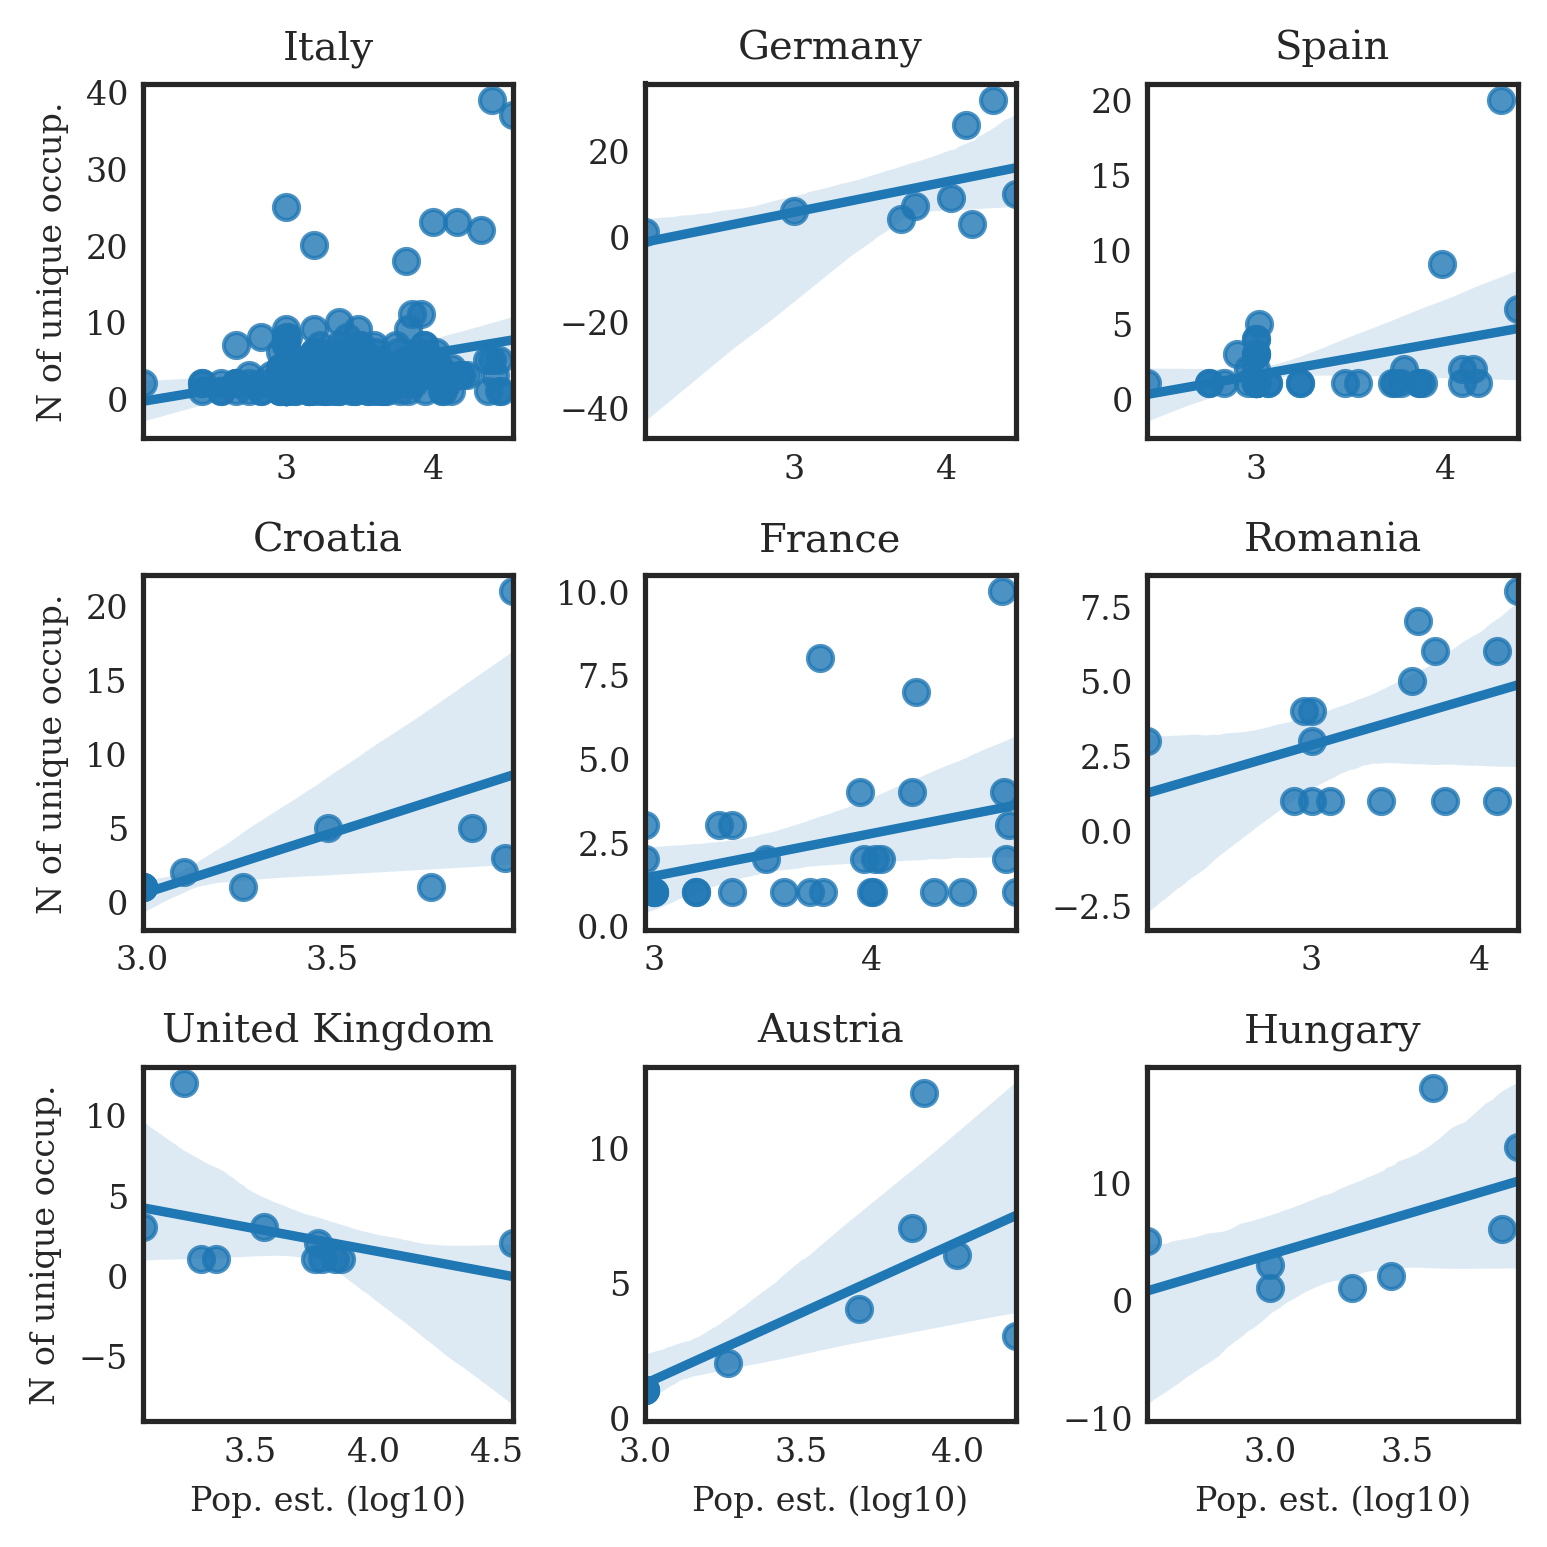

In [459]:
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

fig, axs = plt.subplots(3,3, figsize=[5.2, 5.2], tight_layout=True)
for country, ax in zip(countries_occups_gdf["Country"].tolist()[:9], axs.ravel()):
    country_df = cities_occups_gdf[cities_occups_gdf["Country"]==country]
    if country == "Italy":
        country_df =country_df [1:]
    sns.regplot(x ='pop_est_log', y ='unique_occups_N', data = country_df[country_df["occups_N"]>0][:], ax=ax)
    ax.set_title(country)
    ax.set_ylabel("N of unique occup.")
    ax.set_xlabel("Pop. est. (log10)")
    
[ax.set_ylabel("") for ax in axs[:,1:].ravel()]
[ax.set_xlabel("") for ax in axs[:2,:].ravel()]

In [460]:
s.write_file(figpath + "cites_pop_vs_unique_occupsN.png", fig)
s.write_file(figpath + "cites_pop_vs_unique_occupsN.eps", fig)

A file with the same name ("cites_pop_vs_unique_occupsN.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/cites_pop_vs_unique_occupsN.png"
A file with the same name ("cites_pop_vs_unique_occupsN.eps") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/cites_pop_vs_unique_occupsN.eps"


In [320]:
cities_occups_gdf.sort_values("pop_est", ascending=False).head(5)

,city,pop_est,Country,geometry,ins_N,unique_occups,occups_N,unique_occups_N,pop_est_log
654,Roma,923313.0,Italy,POINT (12.48510 41.89278),37769,"[ornator, signarius, calciator, gerulus, vesti...",1288,203,5.965349
15,Carthago,102074.0,Tunisia,POINT (10.32769 36.85132),411,"[medicus, mensor, argentarius, mesor, agrimensor]",7,5,5.008915
904,Syracusae,83831.0,Italy,POINT (15.28444 37.06648),5,[],0,0,4.923405
879,Agrigentum,53332.0,Italy,POINT (13.57696 37.31119),5,[],0,0,4.726988
240,Vindobriga (Gallia Aquitania) (1),49650.0,France,POINT (0.30974 46.73545),0,[],0,0,4.695919


In [335]:
cities_occups_gdf

,city,pop_est,Country,geometry,ins_N,unique_occups,occups_N,unique_occups_N,pop_est_log,index
0,Roma,923313.0,Italy,POINT (12.48510 41.89278),37769,"[ornator, signarius, calciator, gerulus, vesti...",1288,203,5.965349,0
1,Carthago,102074.0,Tunisia,POINT (10.32769 36.85132),411,"[medicus, mensor, argentarius, mesor, agrimensor]",7,5,5.008915,1
2,Syracusae,83831.0,Italy,POINT (15.28444 37.06648),5,[],0,0,4.923405,2
3,Agrigentum,53332.0,Italy,POINT (13.57696 37.31119),5,[],0,0,4.726988,3
4,Vindobriga (Gallia Aquitania) (1),49650.0,France,POINT (0.30974 46.73545),0,[],0,0,4.695919,4
...,...,...,...,...,...,...,...,...,...,...
902,Musti,106.0,Tunisia,POINT (9.14302 36.33629),12,[],0,0,2.025306,902
903,Circeii (1),106.0,Italy,POINT (13.09627 41.23563),3,[],0,0,2.025306,903
904,Lucentum,106.0,Spain,POINT (-0.48479 38.34602),44,[],0,0,2.025306,904
905,Fagifulae,42.0,Italy,POINT (14.66762 41.65788),28,[],0,0,1.623249,905


<AxesSubplot:xlabel='pop_est_log', ylabel='ins_N'>

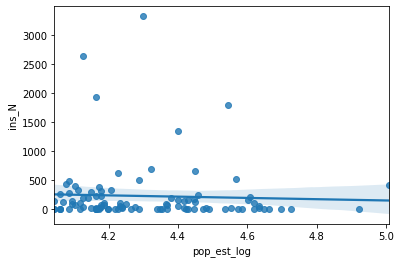

In [334]:
#fig, ax = plt.subplots()
sns.regplot(x ='pop_est_log', y ='ins_N', data = cities_occups_gdf[1:100])

#ax.set(xscale="log", yscale="log")

In [213]:
# cities with at least 5 unique occupations:
len(cities_occups_df[cities_occups_df["unique_occups_N"]>=5])

99

In [149]:
len(cities_occups_pops)

419

In [169]:
cities_occups_pops = cities_occups_pops[cities_occups_pops["city_pop"]>=1000]

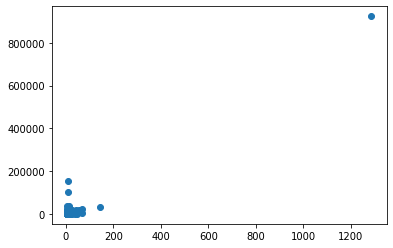

In [159]:
plt.scatter(cities_occups_pops["occups_N"],  cities_occups_pops["city_pop"])

In [161]:
cities_occups_pops

,city,occups_N,city_pop,Country
0,Aeclanum,7,2290.0,Italy
1,Aesernia,10,1559.0,Italy
2,Albintimilium,8,2922.0,Italy
3,Allifae,11,2601.0,Italy
4,Ameria,8,3086.0,Italy
...,...,...,...,...
156,Viminacium (1),10,9280.0,Serbia
157,Vindobona,21,4837.0,Austria
158,Vindonissa,8,1000.0,Switzerland
159,Virunum,12,7172.0,Austria


In [163]:
np.log2(5)

2.321928094887362

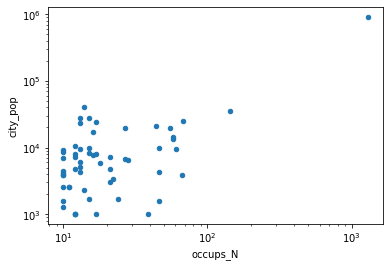

In [170]:
fig, ax = plt.subplots()
cities_occups_pops.plot.scatter("occups_N", "city_pop", ax=ax)
#x = np.log10(cities_occups_pops["occups_N"])
#y = np.log10(cities_occups_pops["city_pop"])
#m, b = np.polyfit(x, y, 1)
#plt.plot(x, m*x + b)

ax.set_yscale('log')
ax.set_xscale('log')

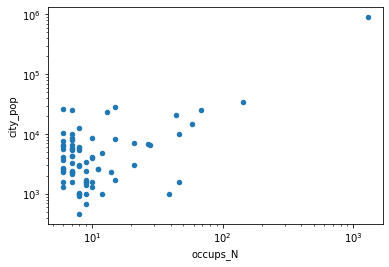

In [135]:
fig, ax = plt.subplots()
cities_occups_pops.plot.scatter("occups_N", "city_pop", ax=ax)
#x = np.log10(cities_occups_pops["occups_N"])
#y = np.log10(cities_occups_pops["city_pop"])
#m, b = np.polyfit(x, y, 1)
#plt.plot(x, m*x + b)

ax.set_yscale('log')
ax.set_xscale('log')

In [166]:
np.log2(cities_occups_pops["occups_N"]).corr(np.log2(cities_occups_pops["city_pop"]))

0.411247203971487

In [139]:
### # pelagios provinces
url = "https://raw.githubusercontent.com/pelagios/magis-pleiades-regions/main/pleiades-regions-magis-pelagios.geojson"
pleiades_regions = gpd.read_file(url)
pleiades_regions

,name,uri,geometry
0,Lusitania,http://pleiades.stoa.org/places/1101,"POLYGON ((-7.31057 37.19663, -7.32457 37.19556..."
1,Byzacena,http://pleiades.stoa.org/places/991345,"MULTIPOLYGON (((11.01815 34.62424, 11.00879 34..."
2,Viennensis,http://pleiades.stoa.org/places/992074,"POLYGON ((4.62344 45.60642, 4.71224 45.60876, ..."
3,Lycia et Pamphylia,http://pleiades.stoa.org/places/981530,"MULTIPOLYGON (((29.62331 36.07470, 29.61295 36..."
4,Savia,http://pleiades.stoa.org/places/991357,"POLYGON ((18.10598 45.77203, 18.10654 45.71079..."
...,...,...,...
142,Aegyptus,http://pleiades.stoa.org/places/981503,"MULTIPOLYGON (((33.96743 27.18697, 33.94941 27..."
143,Raetia,http://pleiades.stoa.org/places/981547,"POLYGON ((7.19022 45.77670, 7.22853 45.93539, ..."
144,Mauretania Caesariensis,http://pleiades.stoa.org/places/285482,"POLYGON ((6.02188 36.86254, 6.11106 36.74744, ..."
145,Galliae,http://pleiades.stoa.org/places/992075,"MULTIPOLYGON (((-2.85190 47.33873, -2.85378 47..."


In [140]:
pleiades_regions

,name,uri,geometry
0,Lusitania,http://pleiades.stoa.org/places/1101,"POLYGON ((-7.31057 37.19663, -7.32457 37.19556..."
1,Byzacena,http://pleiades.stoa.org/places/991345,"MULTIPOLYGON (((11.01815 34.62424, 11.00879 34..."
2,Viennensis,http://pleiades.stoa.org/places/992074,"POLYGON ((4.62344 45.60642, 4.71224 45.60876, ..."
3,Lycia et Pamphylia,http://pleiades.stoa.org/places/981530,"MULTIPOLYGON (((29.62331 36.07470, 29.61295 36..."
4,Savia,http://pleiades.stoa.org/places/991357,"POLYGON ((18.10598 45.77203, 18.10654 45.71079..."
...,...,...,...
142,Aegyptus,http://pleiades.stoa.org/places/981503,"MULTIPOLYGON (((33.96743 27.18697, 33.94941 27..."
143,Raetia,http://pleiades.stoa.org/places/981547,"POLYGON ((7.19022 45.77670, 7.22853 45.93539, ..."
144,Mauretania Caesariensis,http://pleiades.stoa.org/places/285482,"POLYGON ((6.02188 36.86254, 6.11106 36.74744, ..."
145,Galliae,http://pleiades.stoa.org/places/992075,"MULTIPOLYGON (((-2.85190 47.33873, -2.85378 47..."


<AxesSubplot:>

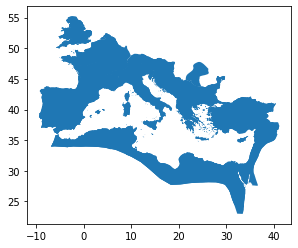

In [138]:
pleiades_regions.plot()